#**Preprocess Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset-20240729T104735Z-001.zip"

Archive:  /content/drive/MyDrive/Dataset-20240729T104735Z-001.zip
  inflating: Dataset/masks/test/img1_mask.png  
  inflating: Dataset/masks/test/img120_mask.png  
  inflating: Dataset/masks/test/img116_mask.png  
  inflating: Dataset/masks/test/img122_mask.png  
  inflating: Dataset/masks/test/img10_mask.png  
  inflating: Dataset/masks/test/img11_mask.png  
  inflating: Dataset/masks/test/img9_mask.png  
  inflating: Dataset/masks/test/img118_mask.png  
  inflating: Dataset/masks/test/img117_mask.png  
  inflating: Dataset/masks/test/img119_mask.png  
  inflating: Dataset/masks/test/img123_mask.png  
  inflating: Dataset/images/train/img63.png  
  inflating: Dataset/images/train/img18.png  
  inflating: Dataset/images/train/img53.png  
  inflating: Dataset/images/train/img113.png  
  inflating: Dataset/images/train/img14.png  
  inflating: Dataset/images/train/img70.png  
  inflating: Dataset/images/train/img13.png  
  inflating: Dataset/images/train/img102.png  
  inflating: Dataset

#**Model Architecture**

In [ ]:
!pip install torch torchvision

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CraterDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        # Load image
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Load corresponding mask
        mask_name = img_name.replace(".png", "_mask.png")  # Replace .png with _mask.png
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}
DATASET_PATH = '/content/Dataset'
IMAGES_PATH = os.path.join(DATASET_PATH, 'images/train')
MASKS_PATH = os.path.join(DATASET_PATH, 'masks/train')
IMAGES_PATH_VAL = os.path.join(DATASET_PATH, 'images/test')
MASKS_PATH_VAL = os.path.join(DATASET_PATH, 'masks/test')
# Instantiate the dataset and dataloaders
train_dataset = CraterDataset(image_dir=IMAGES_PATH, mask_dir=MASKS_PATH, transform=data_transforms['train'])
val_dataset = CraterDataset(image_dir=IMAGES_PATH_VAL, mask_dir=MASKS_PATH_VAL, transform=data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
!git clone https://github.com/milesial/Pytorch-UNet.git
import os
os.chdir('Pytorch-UNet')
!pip install -r requirements.txt
from unet import UNet

# Initialize the model
model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)  # For binary classification, n_classes=1


fatal: destination path 'Pytorch-UNet' already exists and is not an empty directory.


NameError: name 'device' is not defined

In [ ]:
import torch
from unet import UNet

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the device
model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()  # Binary cross-entropy for binary masks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, masks in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

        scheduler.step()

    return model


In [ ]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.8379
val Loss: 0.7471
Epoch 1/9
----------
train Loss: 0.7013
val Loss: 2.3953
Epoch 2/9
----------
train Loss: 0.6623
val Loss: 43.3396
Epoch 3/9
----------
train Loss: 0.5916
val Loss: 41.3473
Epoch 4/9
----------
train Loss: 0.5621
val Loss: 42.0166
Epoch 5/9
----------
train Loss: 0.5194
val Loss: 64.7399
Epoch 6/9
----------
train Loss: 0.4769
val Loss: 36.6858
Epoch 7/9
----------
train Loss: 0.4924
val Loss: 16.1532
Epoch 8/9
----------
train Loss: 0.4482
val Loss: 6.2631
Epoch 9/9
----------
train Loss: 0.4470
val Loss: 3.4499


In [ ]:
def evaluate_model(model):
    model.eval()
    with torch.no_grad():
        for inputs, ma
        sks in val_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = model(inputs)
            # Apply sigmoid to the output to get probabilities
            preds = torch.sigmoid(outputs)
            preds = preds > 0.5  # Threshold to get binary output (0 or 1)

            # You can visualize the results here or calculate accuracy metrics
            # Example: display an image and the predicted mask


In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_results(model, data_loader, num_samples=5):
    model.eval()  # Set the model to evaluation mode

    samples = 0
    with torch.no_grad():  # No need to track gradients during inference
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Get the model's predicted outputs
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = preds > 0.5  # Convert probabilities to binary masks (0 or 1)

            # Move tensors back to CPU for visualization
            images = images.cpu()
            masks = masks.cpu()
            preds = preds.cpu()

            for i in range(images.size(0)):
                if samples >= num_samples:
                    return

                # Visualize image, ground truth, and predicted mask
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                # Original Image
                axs[0].imshow(images[i].permute(1, 2, 0).numpy())  # Permute to convert (C, H, W) -> (H, W, C)
                axs[0].set_title('Original Image')
                axs[0].axis('off')

                # Ground Truth Mask
                axs[1].imshow(masks[i].squeeze().numpy(), cmap='gray')  # Squeeze to remove single channel
                axs[1].set_title('Ground Truth Mask')
                axs[1].axis('off')

                # Predicted Mask
                axs[2].imshow(preds[i].squeeze().numpy(), cmap='gray')  # Squeeze to remove single channel
                axs[2].set_title('Predicted Mask')
                axs[2].axis('off')

                plt.show()
                samples += 1


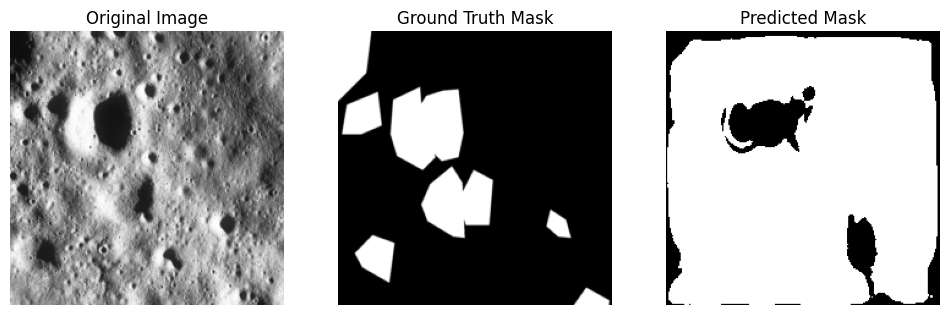

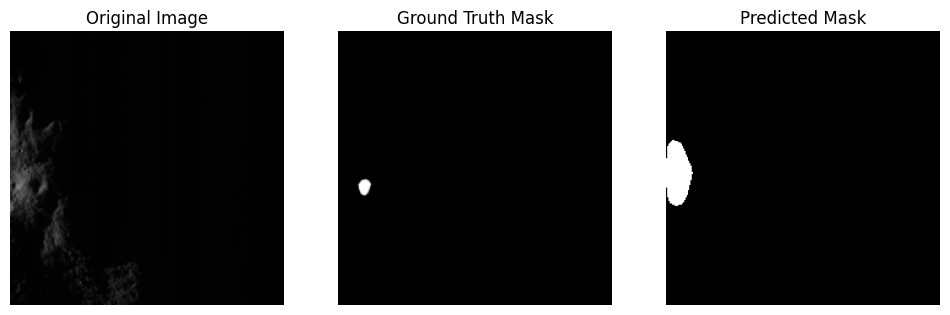

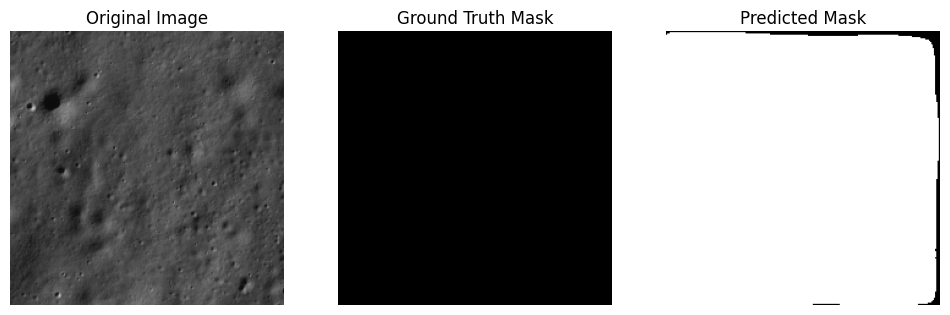

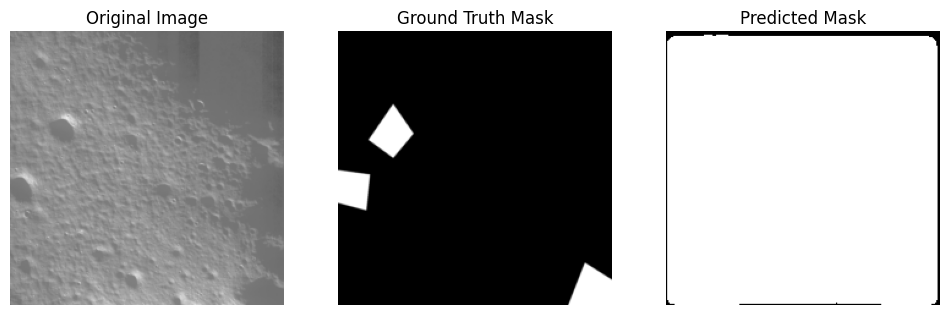

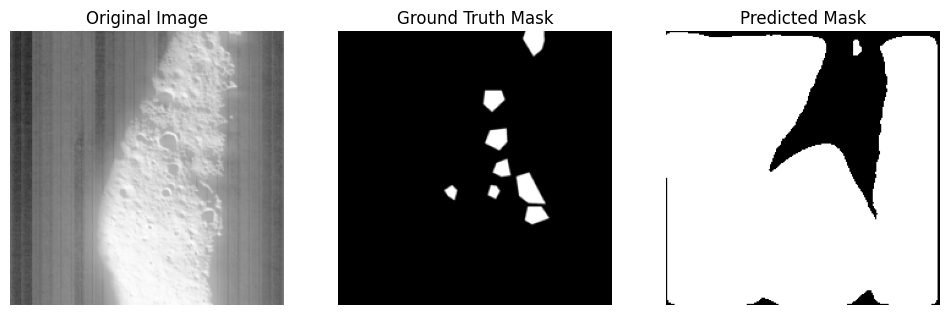

In [ ]:
visualize_results(model, val_loader, num_samples=5)  # Visualize 5 samples from the validation set


#With resnet

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Function to tile large images with padding
def tile_image(image, tile_size):
    img_height, img_width = image.shape[-2], image.shape[-1]
    tile_height, tile_width = tile_size
    tiles = []

    # Padding to ensure even tiles
    pad_h = (tile_height - (img_height % tile_height)) % tile_height
    pad_w = (tile_width - (img_width % tile_width)) % tile_width
    padded_image = F.pad(image, (0, pad_w, 0, pad_h), mode='constant', value=0)  # Padding with zeros

    img_height_padded, img_width_padded = padded_image.shape[-2], padded_image.shape[-1]

    for y in range(0, img_height_padded, tile_height):
        for x in range(0, img_width_padded, tile_width):
            tile = padded_image[:, y:y + tile_height, x:x + tile_width]
            tiles.append(tile)

    return tiles

class MoonCraterDataset(Dataset):
    def __init__(self, image_dir, mask_dir, tile_size=(512, 512), transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])
        self.tile_size = tile_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # Grayscale for mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Tile images and masks
        image_tiles = tile_image(image, self.tile_size)
        mask_tiles = tile_image(mask, self.tile_size)

        # Stack the tiles into tensors
        padded_image_tiles = [F.pad(tile, (0, self.tile_size[1] - tile.shape[2], 0, self.tile_size[0] - tile.shape[1]), mode='constant', value=0) for tile in image_tiles]
        padded_mask_tiles = [F.pad(tile, (0, self.tile_size[1] - tile.shape[2], 0, self.tile_size[0] - tile.shape[1]), mode='constant', value=0) for tile in mask_tiles]

        # Return stacked tensors
        return torch.stack(padded_image_tiles), torch.stack(padded_mask_tiles)

# Transforms for image preprocessing
transform = T.Compose([
    T.ToTensor(),  # Converts to tensor and scales between 0 and 1
])

# Prepare the dataset and dataloader
dataset = MoonCraterDataset(image_dir='/content/Dataset/images/train',
                            mask_dir='/content/Dataset/masks/train',
                            tile_size=(512, 512),
                            transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate skip connection
        x = self.conv_block(x)
        return x

In [ ]:
# U-Net model with ResNet50 backbone
class UNetResNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNetResNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Removing fully connected layers

        # Encoder layers
        self.enc1 = nn.Sequential(*list(resnet.children())[:3])  # conv1
        self.enc2 = nn.Sequential(*list(resnet.children())[3:5])  # layer1
        self.enc3 = list(resnet.children())[5]  # layer2
        self.enc4 = list(resnet.children())[6]  # layer3
        self.enc5 = list(resnet.children())[7]  # layer4

        # Decoder layers
        self.up6 = UpBlock(2048, 1024)
        self.up7 = UpBlock(1024, 512)
        self.up8 = UpBlock(512, 256)
        self.up9 = UpBlock(256, 128)
        self.up10 = UpBlock(128, 64)

        # Final convolution layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        # Decoder with skip connections
        dec6 = self.up6(enc5, enc4)
        dec7 = self.up7(dec6, enc3)
        dec8 = self.up8(dec7, enc2)
        dec9 = self.up9(dec8, enc1)
        dec10 = self.up10(dec9, enc1)

        # Final prediction
        return torch.sigmoid(self.final_conv(dec10))  # Sigmoid for binary segmentation

# Initialize the model
model = UNetResNet(num_classes=1)  # No .cuda() since we are using CPU

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)



In [ ]:
# Training function
def train_model(model, dataloader, optimizer, criterion, num_epochs=50):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, masks in dataloader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Ensure outputs and masks have the same shape before computing loss
            if outputs.shape != masks.shape:
                print(f"Output shape: {outputs.shape}, Mask shape: {masks.shape}")
                continue  # Skip this batch if there's a shape mismatch

            loss = criterion(outputs, masks)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")

# Train the model
train_model(model, dataloader, optimizer, criterion, num_epochs=50)


#**PYCDA**

In [ ]:
!pip install pycda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycda: filename=pycda-0.1.16-py3-none-any.whl size=42163026 sha256=fdb3464c082908c811e2562cec43814677cee2c0a19579c5507d6af4f66e81a3
  Stored in directory: /root/.cache/pip/wheels/1f/54/da/34b24c28779c5018354cc7ba97f1df85e4b2d6a13bd8c87151
Successfully built pycda


In [ ]:
import skimage
print(skimage.__version__)
!pip install --upgrade scikit-image
from skimage.segmentation import watershed
!pip uninstall pycda
!pip install pycda


0.24.0
Found existing installation: pycda 0.1.16
Uninstalling pycda-0.1.16:
  Would remove:
    /usr/local/classifier_12x12_2.h5
    /usr/local/holdout_tile.pgm
    /usr/local/holdout_tile_labels.csv
    /usr/local/lib/python3.10/dist-packages/pycda-0.1.16.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pycda/*
    /usr/local/mercury.png
    /usr/local/rgb_sample.jpg
    /usr/local/selection0.png
    /usr/local/selection2.png
    /usr/local/selection3.png
    /usr/local/selection4.png
    /usr/local/selection5.png
    /usr/local/tinynet.h5
    /usr/local/unet.h5
Proceed (Y/n)? y
  Successfully uninstalled pycda-0.1.16
  Using cached pycda-0.1.16-py3-none-any.whl


In [ ]:
!pip show pycda # to find the location

Name: pycda
Version: 0.1.16
Summary: Python Crater Detection Algorithm (PyCDA) is a pipeline for crater detection; go from image to annotated crater stats in minutes.
Home-page: https://github.com/AlliedToasters/PyCDA
Author: Michael Klear
Author-email: michael.klear@colorado.edu
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: h5py, Keras, numpy, pandas, scikit-image, scikit-learn, tensorflow
Required-by: 


In [ ]:
from pycda import CDA

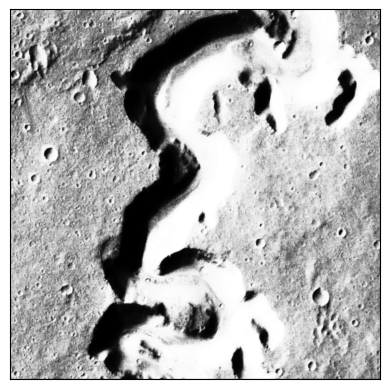

In [ ]:
from pycda.sample_data import get_sample_image
image = get_sample_image()
image.show();

In [ ]:
cda = CDA()

In [ ]:
detections = cda.predict(image)
detections.head(4)

TypeError: label() got an unexpected keyword argument 'neighbors'

In [ ]:
!wget https://raw.githubusercontent.com/AlliedToasters/PyCDA/master/test.py

--2024-10-21 15:50:30--  https://raw.githubusercontent.com/AlliedToasters/PyCDA/master/test.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8884 (8.7K) [text/plain]
Saving to: ‘test.py’

test.py             100%[===================>]   8.68K  --.-KB/s    in 0s      

2024-10-21 15:50:31 (109 MB/s) - ‘test.py’ saved [8884/8884]



In [ ]:
python test.py


SyntaxError: invalid syntax (<ipython-input-19-83c175a3a2f1>, line 1)